# Collision likelihood

Let's consider a multi-device IoT scenario with both Poisson HMMs and Discrete HMMs.
The challenge of detecting collision likelihood becomes a structured learning problem.

### Problem Definition

- Inputs: Base station sees a time series of observed signals with possible collisions.

- Goal: Learn a model that predicts the probability of collision at each time step.

- Devices:
    - 20 devices with categorical emissions (e.g., Discrete HMM).
    - 5 devices with count-based Poisson emissions (e.g., Poisson HMM).

- **total_emission is no longer fully observable**
    - If there's a collision, the BS sees nothing intelligible — just energy or a failed CRC.
    - If there's no collision, the BS may observe a valid decoded message (including payload and source).
    - So, total_emission becomes a partially observable signal.

In [1]:
%%capture
!pip install scikit-learn
!pip install torch
!pip install tqdm

In [2]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
np.random.seed(42)

## Step 1: Simulate Emissions

Simulate each device independently.

Sum up emissions and apply a collision function: If more than one device emits at the same time → collision Else → base station sees total emission.

In [4]:
from devices import SimpleHMM as DiscreteHMM
from devices import PoissonHMM

In [5]:
# Parameters
T = 1000
n_discrete = 20
n_poisson = 5

# HMM models (same for all devices of each type)
A_disc = np.array([[0.97, 0.03],   # idle → idle with high probability
                   [0.7, 0.3]])    # active → idle more likely than staying active

B_disc = np.array([[0.99, 0.01, 0.0],   # idle emits 0 with very high probability
                   [0.7, 0.25, 0.05]])  # active: mostly emits 0–1, rarely 2
pi_disc = [1.0, 0.0]

# Poisson-based HMM
A_pois = np.array([[0.98, 0.02],   # idle → idle is very likely
                   [0.6, 0.4]])    # active → idle more likely than staying active

lambda_pois = [0.05, 1.0]          # lower emission intensity

pi_pois = [1.0, 0.0]

In [6]:
def sample_discrete_hmm(T):
    device = DiscreteHMM(A_disc, B_disc, pi_disc)
    states, emissions = device.sample(T)
    return emissions

def sample_poisson_hmm(T):
    device = PoissonHMM(A_pois, lambda_pois, pi_pois)
    states, emissions = device.sample(T)
    return emissions  

In [7]:
# Generate emissions from all devices
emissions = []
for _ in range(n_discrete):
    emissions.append(sample_discrete_hmm(T))
for _ in range(n_poisson):
    emissions.append(sample_poisson_hmm(T))
emissions = np.array(emissions)

## Step 2: Create Dataset

For each time step:
- Input: scalar total emission (combined_obs[t])
- Label: 1 if collision occurred, 0 otherwise.

The base station may also estimate:
- Number of active transmitters: active_devices[t]
- Derivatives: delta_emission = [x[t] - x[t-1] for t]
- Rolling stats: mean, std in past n

In [8]:
# Base station view: sum + collision label
total_emission = emissions.sum(axis=0)

noise = np.random.normal(loc=0.0, scale=0.5, size=T)
signal_strength_per_device = 1.0
raw_energy = total_emission * signal_strength_per_device + noise

decoded_payload = (total_emission == 1).astype(int)   # Success if only one device transmits
collision_flag = (total_emission > 1).astype(int)     # Collision if more than one transmits

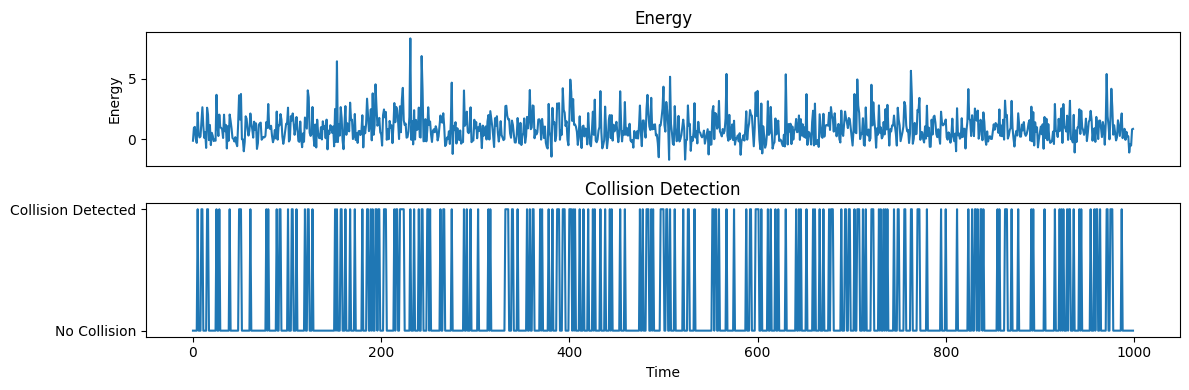

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(211)
plt.plot(raw_energy, label="raw energy")
plt.xticks([], [])
plt.ylabel("Energy")
plt.title("Energy")

plt.subplot(212)
plt.plot(collision_flag, label="True collisions")
plt.xlabel("Time")
plt.yticks([0, 1], ['No Collision', 'Collision Detected'])
plt.title("Collision Detection")

plt.tight_layout()
plt.show()

# Step 3: Train a Model

Train a DL model (*e.g.* RNN or transformed) to classify collision likelihood from the observable signal.

We keep the input as a sliding window of emissions (past n steps).
We also use a lightweight Transformer encoder to process sequences.

The model is trained as a binary classifier: collision (1) vs no collision (0).

In [10]:
n_context = 10  # number of time steps to consider in the classification

Use the enhanced feature set with n_context time steps as a sequence input for a Transformer

In [11]:
T_effective = T - n_context + 1

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Use the enhanced feature set with **n_context** time steps as a sequence input for a Transformer. 
Each time step has multiple features:

- Raw emission
- Delta (emission diff)
- Active devices
- Time since last 0-emission (same value repeated over window)

So, total feature vector per step = 4, and total input shape per sample => [n_context, 4]

In [13]:
def extract_features_with_silence(raw_energy, decoded_payload, collision_flag, n_context):
    X = []
    y = []

    for t in range(n_context - 1, len(raw_energy)):
        energy_window = raw_energy[t - n_context + 1:t + 1]
        success_window = decoded_payload[t - n_context + 1:t + 1]

        # Time since last success
        reversed_success = success_window[::-1]
        try:
            last_success_idx = np.where(reversed_success == 1)[0][0]
        except IndexError:
            last_success_idx = n_context
        silence_vector = np.full(n_context, last_success_idx)

        # Feature shape: [n_context, 3]
        features = np.stack([energy_window, success_window, silence_vector], axis=1)
        X.append(features)
        y.append(collision_flag[t])


    return np.array(X), np.array(y)

In [14]:
# Create input features
X, y = extract_features_with_silence(raw_energy, decoded_payload, collision_flag, n_context)

In [15]:
# Split into train/test

split = int(0.8 * len(X))
X_train = torch.tensor(X[:split], dtype=torch.float32).to(device)
X_test  = torch.tensor(X[split:], dtype=torch.float32).to(device)

y_train = torch.tensor(y[:split], dtype=torch.float32).to(device)
y_test  = torch.tensor(y[split:], dtype=torch.float32).to(device)

In [16]:
X_train.shape

torch.Size([792, 10, 3])

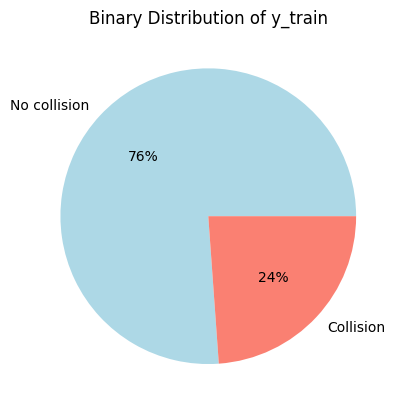

In [17]:
# Count occurrences of each category
labels, counts = np.unique(y_train.cpu().numpy(), return_counts=True)

# Create pie chart
plt.pie(counts, labels=["No collision" if int(x) == 0 else "Collision" for x in labels], autopct='%1.0f%%', colors=['lightblue', 'salmon'])

# Add title
plt.title('Binary Distribution of y_train')
plt.show()

## Model

In [18]:
# Transformer-based model
class CollisionTransformer(nn.Module):
    
    def __init__(self, input_dim, d_model=16, nhead=2, num_layers=2, use_sigmoid=False):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls = nn.Linear(d_model, 1)
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        x = self.input_proj(x)                     # [B, T, d_model]
        x = self.transformer(x)                    # [B, T, d_model]
        x = x.mean(dim=1)                          # global average pooling over time
        x = self.cls(x).squeeze(-1)                # [B]
        if self.use_sigmoid:
            return torch.sigmoid(x)
        else:
            return x

In [19]:
# Instantiate
lr = 0.0001

model = CollisionTransformer(input_dim=X_train.shape[-1], nhead=4, num_layers=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss_fn = nn.BCELoss()

# to try to fix unbalanced data
pos_weight = torch.tensor([ (y_train == 0).sum() / (y_train == 1).sum() ]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Note: Remove sigmoid from model!

In [20]:
X_train.shape

torch.Size([792, 10, 3])

In [21]:
# Training loop
epochs = 500
losses = []
n_steps_show = epochs // 10
for epoch in tqdm(range(epochs)):
    model.train()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch + 1) % n_steps_show == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

 10%|████████▎                                                                         | 51/500 [00:04<00:35, 12.78it/s]

Epoch 50, Loss: 0.7487


 20%|████████████████▎                                                                | 101/500 [00:08<00:31, 12.67it/s]

Epoch 100, Loss: 0.7188


 30%|████████████████████████▍                                                        | 151/500 [00:12<00:27, 12.77it/s]

Epoch 150, Loss: 0.7050


 40%|████████████████████████████████▌                                                | 201/500 [00:16<00:23, 12.57it/s]

Epoch 200, Loss: 0.6848


 50%|████████████████████████████████████████▋                                        | 251/500 [00:20<00:19, 12.55it/s]

Epoch 250, Loss: 0.6642


 60%|████████████████████████████████████████████████▊                                | 301/500 [00:23<00:15, 12.71it/s]

Epoch 300, Loss: 0.6504


 70%|████████████████████████████████████████████████████████▊                        | 351/500 [00:27<00:11, 12.68it/s]

Epoch 350, Loss: 0.6272


 80%|████████████████████████████████████████████████████████████████▉                | 401/500 [00:33<00:08, 11.57it/s]

Epoch 400, Loss: 0.6409


 90%|█████████████████████████████████████████████████████████████████████████        | 451/500 [00:37<00:03, 12.77it/s]

Epoch 450, Loss: 0.6018


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:40<00:00, 12.22it/s]

Epoch 500, Loss: 0.5824


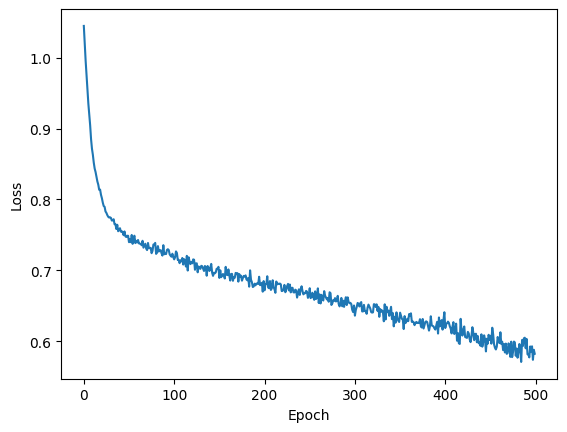

In [22]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [23]:
# Evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()
    y_pred_cls = (y_pred > 0.5).astype(int)
    y_true = y_test.cpu().numpy()

print(classification_report(y_true, y_pred_cls))

              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85       159
         1.0       0.43      0.47      0.45        40

    accuracy                           0.77       199
   macro avg       0.65      0.66      0.65       199
weighted avg       0.78      0.77      0.77       199



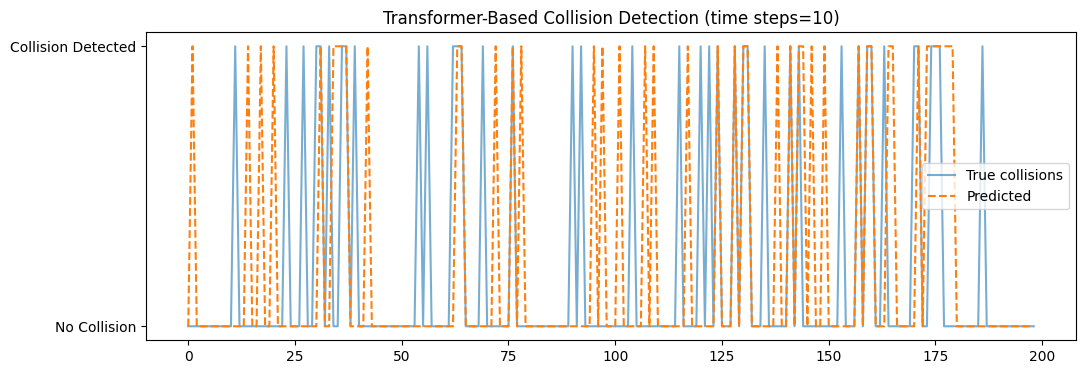

In [24]:
# Plot results
plt.figure(figsize=(12, 4))
plt.plot(y_true, label="True collisions", alpha=0.6)
plt.plot(y_pred_cls, label="Predicted", linestyle='--')
plt.yticks([0, 1], ['No Collision', 'Collision Detected'])
plt.legend()
plt.title(f"Transformer-Based Collision Detection (time steps={n_context})")
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score, average_precision_score

print("AUC:", roc_auc_score(y_test.cpu(), y_pred_cls))
print("PR AUC:", average_precision_score(y_test.cpu(), y_pred_cls))

AUC: 0.6588836477987422
PR AUC: 0.3106412745545911


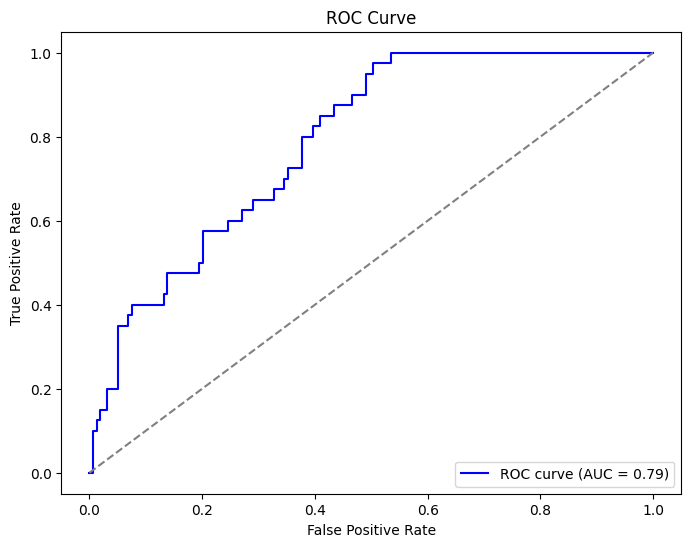

In [26]:
from sklearn.metrics import roc_curve, auc

y_scores = torch.sigmoid(torch.tensor(y_pred)).numpy() 

fpr, tpr, _ = roc_curve(y_test.cpu(), y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

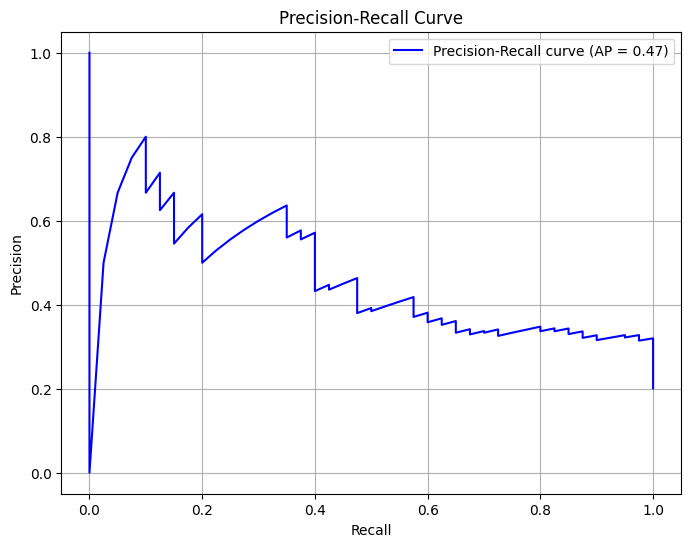

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test.cpu(), y_scores)

# Compute Average Precision (AP) score
ap_score = average_precision_score(y_test.cpu(), y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()